In [55]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [56]:
Train_data = pd.read_csv('E:\Traindata_for_tree_own.csv')

In [57]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
Train_data=reduce_mem_usage(Train_data)

Memory usage of dataframe is 43199490.00 MB
Memory usage after optimization is: 11549912.00 MB
Decreased by 73.3%


In [58]:
Train_data['city']=Train_data['city'].fillna(0).astype(float)


In [59]:

Train_data=Train_data.drop('SaleID',axis=1)
continuous_feature_names = [x for x in Train_data.columns if x not in 'price']

train_x = Train_data[continuous_feature_names]   #训练集x值

#在这里我们对标签进行了 log(x+1) 变换，使标签贴近于正态分布

train_y =np.log(Train_data['price']+1)       #训练集y值
print(train_y_ln)

0         7.523481
1         8.188967
2         8.736007
3         7.783641
4         8.556606
            ...   
149993    8.682877
149994    9.159152
149995    8.922792
149996    8.517193
149997    8.455531
Name: price, Length: 149998, dtype: float64


In [60]:
Test_data = reduce_mem_usage(pd.read_csv('E:\Testdata_for_tree_own.csv'))
Test_data['city']=Test_data['city'].fillna(0).astype(float)

T=Test_data.copy()#复制一份

Test_data=Test_data.drop('SaleID',axis=1)
continuous_feature_names = [x for x in Test_data.columns]

test_x = Test_data[continuous_feature_names]   #测试集x值

Memory usage of dataframe is 14000066.00 MB
Memory usage after optimization is: 3650066.00 MB
Decreased by 73.9%


In [61]:
Train_data.info()
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149998 entries, 0 to 149997
Data columns (total 35 columns):
model                  149998 non-null float16
brand                  149998 non-null int8
bodyType               149998 non-null float16
fuelType               149998 non-null float16
gearbox                149998 non-null float16
power                  149998 non-null int16
kilometer              149998 non-null float16
notRepairedDamage      149998 non-null float16
price                  149998 non-null int32
v_0                    149998 non-null float16
v_1                    149998 non-null float16
v_2                    149998 non-null float16
v_3                    149998 non-null float16
v_4                    149998 non-null float16
v_5                    149998 non-null float16
v_6                    149998 non-null float16
v_7                    149998 non-null float16
v_8                    149998 non-null float16
v_9                    149998 non-null float16
v_1

In [48]:
#随机森林模型

rf = RandomForestRegressor()
n_estimators=[300,500]         #树的数量
max_depth=[6,8]
param_grid = { "max_depth": max_depth, "n_estimators": n_estimators}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
gs = gs.fit(train_x, train_y)
print('best_score_:',gs.best_score_)
print('best_params_:',gs.best_params_)




Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 82.8min finished


best_score_: 0.942596798615973
best_params_: {'max_depth': 8, 'n_estimators': 300}


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [50]:
bp = gs.best_params_
forest = RandomForestRegressor(max_depth=bp['max_depth'],n_estimators=bp['n_estimators'])


In [52]:
forest_1=forest.fit(train_x, train_y)
y=forest_1.predict(test_x)
test_y=np.exp(y)

sub1 = pd.DataFrame()
sub1['SaleID'] = Test_data.SaleID
sub1['price'] = test_y

sub1.head()

,SaleID,price
0,150000,38021.357522
1,150001,382.735299
2,150002,6351.105343
3,150003,11788.077726
4,150004,598.583052


In [54]:

sub1['price'].describe()
sub1.to_csv('F:/sub_Weighted.csv',index=False)

In [65]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer
#随机森林贝叶斯调参
rf = RandomForestRegressor()
def rf_cv(n_estimators, max_depth, min_samples_split,max_features, min_samples_leaf):
    val = cross_val_score(
        RandomForestRegressor(
            min_samples_leaf=int(min_samples_leaf),
            min_samples_split=int(min_samples_split),
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            max_features=int(max_features)
        ),
        train_x, train_y_ln, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 250),
        'min_samples_leaf': (1, 80),
        'min_samples_split': (20, 150),
        'max_depth':(5, 30),
        'max_features':(4,10)}
    )

rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.841    |  16.08    |  5.033    |  39.2     |  51.45    |  151.0    |
|  2        |  0.795    |  7.448    |  4.649    |  59.91    |  44.19    |  173.9    |
|  3        |  0.8387   |  26.25    |  9.15     |  69.06    |  70.72    |  124.3    |
|  4        |  0.8371   |  23.56    |  9.037    |  78.92    |  115.3    |  173.3    |
|  5        |  0.8383   |  21.88    |  7.147    |  63.41    |  123.3    |  210.8    |
|  6        |  0.8405   |  13.66    |  7.113    |  1.463    |  145.9    |  60.27    |
|  7        |  0.8572   |  29.43    |  4.997    |  2.99     |  21.67    |  224.8    |
|  8        |  0.8446   |  28.01    |  9.687    |  1.458    |  147.7    |  192.2    |
|  9        |  0.8598   |  20.26    |  8.414    |  4.63     |  25.89    |  62.35    |
|  10       |  0.8428   |  28.67    |  4.225    |  3.9

In [69]:
forest = RandomForestRegressor(max_depth=20,n_estimators=63,min_samples_split=26,min_samples_leaf=5,max_features=9)
forest_2=forest.fit(train_x, train_y)
y=forest_2.predict(test_x)
test_y=np.exp(y)

sub2 = pd.DataFrame()
sub2['SaleID'] = T.SaleID
sub2['price'] = test_y


,SaleID,price
0,150000,38021.357522
1,150001,382.735299
2,150002,6351.105343
3,150003,11788.077726
4,150004,598.583052


In [77]:
sub2['price'].describe()

count    50000.000000
mean      5773.044349
std       7083.866617
min         21.595234
25%       1329.100565
50%       3188.479481
75%       7561.485443
max      84449.124560
Name: price, dtype: float64

In [78]:
sub2.to_csv('F:/sub_Weighted.csv',index=False)

In [219]:
continuous_feature_names = [x for x in Train_data.columns if x not in ['price','usetime_bin','usetime_amount','usetime_price_max',\
                                                                       'usetime_price_median','usetime_price_min','usetime_price_sum','brand_price_std','brand_price_average']

train_x0 = Train_data[continuous_feature_names]   #训练集x值


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149998 entries, 0 to 149997
Data columns (total 43 columns):
model                    149998 non-null float16
brand                    149998 non-null int8
bodyType                 149998 non-null float16
fuelType                 149998 non-null float16
gearbox                  149998 non-null float16
power                    149998 non-null int16
kilometer                149998 non-null float16
notRepairedDamage        149998 non-null float16
price                    149998 non-null int32
v_0                      149998 non-null float16
v_1                      149998 non-null float16
v_2                      149998 non-null float16
v_3                      149998 non-null float16
v_4                      149998 non-null float16
v_5                      149998 non-null float16
v_6                      149998 non-null float16
v_7                      149998 non-null float16
v_8                      149998 non-null float16
v_9           

In [81]:
train_y_notln=Train_data['price']
#xgb模型调参
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_x, train_y_notln, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 150),
        'learning_rate': (0.05, 0.13),
        'max_depth':(5, 12),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -787.7    |  0.07772  |  5.373    |  83.61    |  0.1812   |
|  2        | -579.9    |  0.09454  |  9.925    |  85.97    |  0.9876   |
|  3        | -590.0    |  0.1246   |  11.53    |  102.3    |  0.4024   |
|  4        | -775.5    |  0.09963  |  5.356    |  65.38    |  0.3907   |
|  5        | -553.8    |  0.08802  |  11.97    |  124.7    |  0.7329   |
|  6        | -579.2    |  0.1138   |  11.25    |  66.21    |  0.593    |
|  7        | -587.7    |  0.1103   |  10.48    |  89.47    |  0.5133   |
|  8        | -552.4    |  0.08802  |  11.99    |  124.8    |  0.736    |
|  9        | -577.7    |  0.1115   |  9.807    |  86.0     |  0.9468   |
|  10       | -550.6    |  0.08802  |  12.0     |  124.8    |  0.7365   |
|  11       | -723.1    |  0.09181  |  6.501    |  132.9    |  0.1995   |
|  12       | -588.4    |  0.1282   | 

In [82]:
'''#Step 4:模型训练与预测
#（1) 利用xgb进行五折交叉验证查看模型的参数效果
## xgb-Model
xgr_1 = xgb.XGBRegressor(n_estimators=125, learning_rate=0.088, gamma=0, subsample=0.7365,\
        colsample_bytree=0.9, max_depth=12) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(train_x,train_y_notln):
    
    train_x_train=train_x.iloc[train_ind].values
    train_y_train=train_y_notln.iloc[train_ind]
    val_x=train_x.iloc[val_ind].values
    val_y=train_y.iloc[val_ind]
    
    xgr_1.fit(train_x,train_y_notln)
    #pred_train_xgb=xgr_1.predict(train_x_train)
    #pred_xgb=xgr_1.predict(val_x)
    
    #score_train = mean_absolute_error(train_y_train,pred_train_xgb)
    #scores_train.append(score_train)
    #score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))'''

ValueError: feature_names mismatch: ['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'usetime', 'city', 'bought_time_bin', 'brand_amount', 'brand_price_max', 'brand_price_median', 'brand_price_min', 'brand_price_sum', 'brand_price_std', 'brand_price_average', 'power_bin'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33']
expected v_11, model, v_14, kilometer, brand_price_max, v_12, power, brand_price_min, brand_price_std, v_13, bodyType, fuelType, notRepairedDamage, bought_time_bin, v_2, brand_price_median, brand_price_sum, v_1, city, brand, v_7, brand_price_average, v_9, v_8, v_0, v_5, v_10, v_4, v_6, brand_amount, gearbox, power_bin, v_3, usetime in input data
training data did not have the following fields: f5, f33, f16, f20, f7, f10, f9, f28, f1, f11, f4, f26, f12, f23, f19, f32, f14, f17, f21, f18, f25, f30, f0, f2, f6, f31, f13, f15, f24, f22, f27, f3, f8, f29

In [84]:
#定义xgb模型函数
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=125, learning_rate=0.088, gamma=0, subsample=0.7365,\
        colsample_bytree=0.9, max_depth=12) #,objective ='reg:squarederror'
    model.fit(train_x, train_y_notln)
    return model
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train_x,train_y_notln,test_size=0.3)

## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))#最大与最小值的差
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Train xgb...')
model_xgb = build_model_xgb(train_x,train_y_notln)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(train_x,train_y_notln)
subA_xgb = model_xgb_pre.predict(test_x)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)



Train xgb...
MAE of val with xgb: 283.5035593203386
Predict xgb...
Sta of Predict xgb:
_min -115.43544
_max: 95200.86
_mean 5920.365
_ptp 95316.3
_std 7361.746
_var 54195304.0


In [88]:
#输出结果
sub3 = pd.DataFrame()
sub3['SaleID'] = T.SaleID
sub3['price'] = subA_xgb
sub3['price'] =sub3['price'].apply(lambda x :12 if x<12 else x)
sub3.to_csv('D:/sub_Weighted.csv',index=False)
sub3['price'].describe()

count    50000.000000
mean      5920.379699
std       7361.808558
min         12.000000
25%       1368.204163
50%       3265.559570
75%       7714.408936
max      95200.859375
Name: price, dtype: float64

In [98]:
## 简单的随机森林和xgb的线性staaking

from sklearn import linear_model
def Stacking_method(train_reg1,train_reg2,y_train_true,test_pre1,test_pre2,model_L2= linear_model.LinearRegression()):
    model_L2.fit(pd.concat([pd.Series(train_reg1),pd.Series(train_reg2)],axis=1).values,y_train_true)
    Stacking_result = model_L2.predict(pd.concat([pd.Series(test_pre1),pd.Series(test_pre2)],axis=1).values)
    return Stacking_result

## 生成一些简单的样本数据，test_prei 代表第i个模型的预测值
train_reg1 = forest_2.predict(train_x)
train_reg2 = model_xgb_pre.predict(train_x)
#   train_reg3 = [3.1, 7.9, 9.2, 5.0]
# y_test_true 代表第模型的真实值
y_train_true = train_y_notln

test_pre1 = sub2['price']
test_pre2 = sub3['price']
print(test_pre2.describe())
#    test_pre3 = [1.1, 2.9, 2.2, 6.0]

model_L2= linear_model.LinearRegression()
Stacking_pre = Stacking_method(train_reg1,train_reg2,y_train_true,
                               test_pre1,test_pre2,model_L2)
#Stacking_pre为最后的预测值

sub_sum = pd.DataFrame()
sub_sum['SaleID'] = T.SaleID
sub_sum['price'] = Stacking_pre
#sub_sum['price']=sub_sum['price'].apply(lambda x:12 if x<12 else x)
sub_sum.to_csv('G:/sub_Weighted.csv',index=False)
sub_sum['price'].describe()

count    50000.000000
mean      5773.044349
std       7083.866617
min         21.595234
25%       1329.100565
50%       3188.479481
75%       7561.485443
max      84449.124560
Name: price, dtype: float64
count    50000.000000
mean      5920.379699
std       7361.808558
min         12.000000
25%       1368.204163
50%       3265.559570
75%       7714.408936
max      95200.859375
Name: price, dtype: float64


count    5.000000e+04
mean    -7.030061e+04
std      8.631047e+04
min     -1.027155e+06
25%     -9.226878e+04
50%     -3.876841e+04
75%     -1.610650e+04
max     -1.439405e+02
Name: price, dtype: float64

In [99]:
#xgb模型调参
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_x, train_y_notln, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 150),
        'learning_rate': (0.05, 0.13),
        'max_depth':(5, 16),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -643.1    |  0.08863  |  10.43    |  65.11    |  0.1772   |
|  2        | -694.1    |  0.09355  |  7.816    |  63.53    |  0.2983   |
|  3        | -616.4    |  0.0761   |  8.064    |  79.3     |  0.9497   |
|  4        | -618.5    |  0.07391  |  9.037    |  91.54    |  0.3684   |
|  5        | -580.3    |  0.08746  |  9.437    |  116.6    |  0.6409   |
|  6        | -582.7    |  0.08697  |  9.469    |  116.7    |  0.6223   |
|  7        | -616.4    |  0.07942  |  9.561    |  116.5    |  0.3252   |
|  8        | -588.8    |  0.05484  |  15.82    |  77.48    |  0.2436   |
|  9        | -609.8    |  0.1192   |  8.761    |  119.6    |  0.486    |
|  10       | -570.4    |  0.09583  |  9.395    |  116.6    |  0.8242   |
|  11       | -603.1    |  0.08812  |  15.65    |  77.33    |  0.1797   |
|  12       | -572.4    |  0.08628  | 

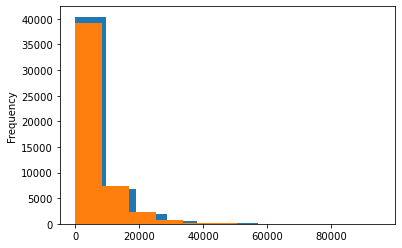

In [100]:
sub3['price'].plot.hist()
sub2['price'].plot.hist()

In [102]:
sub_sum = pd.DataFrame()
sub_sum['SaleID'] = T.SaleID
sub_sum['price'] = 0.6*sub2['price']+0.4*sub3['price']
#sub_sum['price']=sub_sum['price'].apply(lambda x:12 if x<12 else x)
sub_sum.to_csv('G:/sub_Weighted.csv',index=False)
sub_sum['price'].describe()

count    50000.000000
mean      5831.978489
std       7183.561430
min         17.757141
25%       1347.725720
50%       3220.877874
75%       7618.161081
max      86201.812236
Name: price, dtype: float64

In [114]:
T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 35 columns):
SaleID                 50000 non-null int32
model                  50000 non-null float16
brand                  50000 non-null int8
bodyType               50000 non-null float16
fuelType               50000 non-null float16
gearbox                50000 non-null float16
power                  50000 non-null int16
kilometer              50000 non-null float16
notRepairedDamage      50000 non-null float16
v_0                    50000 non-null float16
v_1                    50000 non-null float16
v_2                    50000 non-null float16
v_3                    50000 non-null float16
v_4                    50000 non-null float16
v_5                    50000 non-null float16
v_6                    50000 non-null float16
v_7                    50000 non-null float16
v_8                    50000 non-null float16
v_9                    50000 non-null float16
v_10                   5

In [131]:
#精准数据集的训练集1 2
train_reg1=pd.DataFrame(Train_data[Train_data['price']>30000])
train_reg2=pd.DataFrame(Train_data[Train_data['price']<=30000])

#训练集1x
continuous_feature_names1 = [x for x in train_reg1.columns if x not in 'price']
train_reg1_trainx = train_reg1[continuous_feature_names]   #训练集x值

#训练集2x
continuous_feature_names2 = [x for x in train_reg2.columns if x not in 'price']
train_reg2_trainx = train_reg2[continuous_feature_names]   #训练集x值

In [132]:
#训练集1y
train_reg1_trainy = train_reg1['price']   #训练集1y值

#训练集2y
train_reg2_trainy = train_reg2['price']   #训练集2y值

In [136]:
#精准测试集
T1=T.copy()                                #备份训练集
T1['pricehat']=sub3['price']
Test_reg1=pd.DataFrame(T1[T1['pricehat']>30000])
Test_reg2=pd.DataFrame(T1[T1['pricehat']<=30000])
t1=Test_reg1.copy()                        #备份测试集1
t2=Test_reg2.copy()                        #备份测试集2

In [138]:
#测试集1x
continuous_feature_names11 = [x for x in Test_reg1.columns if x not in ['pricehat','SaleID']]
test_reg1_testx = Test_reg1[continuous_feature_names11]   #训练集x值

#测试集2x
continuous_feature_names22 = [x for x in Test_reg2.columns if x not in ['pricehat','SaleID']]
test_reg2_testx = Test_reg2[continuous_feature_names11]   #训练集x值

In [135]:
#xgb模型model1调参（大于30000）
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_reg1_trainx, train_reg1_trainy, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 150),
        'learning_rate': (0.05, 0.13),
        'max_depth':(5, 13),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -3.211e+0 |  0.1281   |  10.9     |  86.89    |  0.3851   |
|  2        | -3.194e+0 |  0.1132   |  9.442    |  86.22    |  0.4939   |
|  3        | -3.194e+0 |  0.07228  |  12.05    |  82.22    |  0.3114   |
|  4        | -3.252e+0 |  0.05636  |  5.828    |  136.2    |  0.3943   |
|  5        | -3.113e+0 |  0.1115   |  5.255    |  127.5    |  0.4334   |
|  6        | -3.158e+0 |  0.05638  |  12.73    |  107.4    |  0.2295   |
|  7        | -3.156e+0 |  0.1115   |  5.277    |  127.5    |  0.4153   |
|  8        | -3.059e+0 |  0.07126  |  11.9     |  106.3    |  0.7756   |
|  9        | -3.178e+0 |  0.1014   |  11.05    |  90.81    |  0.3456   |
|  10       | -3.184e+0 |  0.08744  |  11.7     |  82.61    |  0.291    |
|  11       | -3.133e+0 |  0.1137   |  9.227    |  121.0    |  0.9625   |
|  12       | -3.181e+0 |  0.08693  | 

In [142]:
#定义xgb模型model1函数，预测出大于30000的数据predict1
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=103, learning_rate=0.08006, gamma=0, subsample=0.4062,\
        colsample_bytree=0.9, max_depth=11) #,objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train_reg1_trainx,train_reg1_trainy,test_size=0.3)

## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))#最大与最小值的差
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Train xgb...')
model_xgb = build_model_xgb(train_reg1_trainx,train_reg1_trainy)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(train_reg1_trainx,train_reg1_trainy)
predict1 = model_xgb_pre.predict(test_reg1_testx)
print('Sta of Predict xgb:')
Sta_inf(predict1)

Train xgb...
MAE of val with xgb: 1074.7009056712964
Predict xgb...
Sta of Predict xgb:
_min 30692.752
_max: 92764.69
_mean 43261.395
_ptp 62071.938
_std 11989.703
_var 143753000.0


In [140]:
#xgb模型model2调参（小于或等于30000）
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_reg2_trainx, train_reg2_trainy, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 150),
        'learning_rate': (0.05, 0.13),
        'max_depth':(5, 13),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -573.5    |  0.06968  |  7.722    |  132.7    |  0.3788   |
|  2        | -519.4    |  0.1081   |  8.328    |  144.5    |  0.7796   |
|  3        | -530.7    |  0.09476  |  9.997    |  88.8     |  0.5361   |
|  4        | -549.5    |  0.07961  |  7.586    |  147.1    |  0.8133   |
|  5        | -535.9    |  0.08619  |  10.83    |  105.0    |  0.2776   |
|  6        | -538.1    |  0.1111   |  11.66    |  64.96    |  0.349    |
|  7        | -496.5    |  0.09506  |  11.04    |  137.2    |  0.8837   |
|  8        | -551.5    |  0.05083  |  12.78    |  74.09    |  0.2915   |
|  9        | -601.6    |  0.07729  |  6.242    |  107.1    |  0.7933   |
|  10       | -610.8    |  0.06299  |  6.202    |  108.9    |  0.8083   |
|  11       | -496.0    |  0.09554  |  11.09    |  137.3    |  0.8919   |
|  12       | -496.5    |  0.1001   | 

In [149]:
#定义xgb模型model2函数，预测出小于或等于30000的数据predict2
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=137, learning_rate=0.09, gamma=0, subsample=0.9,\
        colsample_bytree=0.9, max_depth=11) #,objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train_reg2_trainx,train_reg2_trainy,test_size=0.3)

## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))#最大与最小值的差
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Train xgb...')
model_xgb = build_model_xgb(train_reg2_trainx,train_reg2_trainy)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre1 = build_model_xgb(train_reg2_trainx,train_reg2_trainy)
predict2 = model_xgb_pre1.predict(test_reg2_testx)
print('Sta of Predict xgb:')
Sta_inf(predict2)

Train xgb...
MAE of val with xgb: 250.31458373155152
Predict xgb...
Sta of Predict xgb:
_min -118.29372
_max: 29766.498
_mean 5348.886
_ptp 29884.791
_std 5624.557
_var 31635642.0


In [150]:
df1=pd.DataFrame()
df1['SaleID']=t1.SaleID
df1['price']=predict1

df2=pd.DataFrame()
df2['SaleID']=t2.SaleID
df2['price']=predict2

df_sum1=pd.concat([df1,df2],axis=0)
df_sum1=df_sum1.sort_values(by='SaleID')

In [151]:
df_sum1['price']=df_sum1['price'].apply(lambda x:10 if x<10 else x)
df_sum1.to_csv('D:/sub_Weighted.csv',index=False)

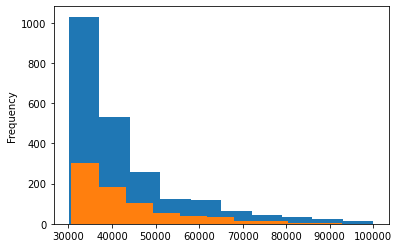

In [156]:
Train_data[Train_data['price']>30000]['price'].plot.hist()
df_sum1[df_sum1['price']>30000]['price'].plot.hist()

In [153]:
#随机森林
#精准数据集的训练集3 4
train_reg3=pd.DataFrame(Train_data[Train_data['price']>30000])
train_reg4=pd.DataFrame(Train_data[Train_data['price']<=30000])

#训练集3x
continuous_feature_names3 = [x for x in train_reg3.columns if x not in 'price']
train_reg3_trainx = train_reg3[continuous_feature_names3]   #训练集3x值

#训练集4x
continuous_feature_names4 = [x for x in train_reg4.columns if x not in 'price']
train_reg4_trainx = train_reg4[continuous_feature_names]   #训练集4x值

In [154]:
#训练集3y
train_reg3_trainy = train_reg3['price']   #训练集3y值

#训练集4y
train_reg4_trainy = train_reg4['price']   #训练集4y值

#精准测试集
T1=T.copy()                                #备份训练集
T1['pricehat']=sub3['price']
Test_reg3=pd.DataFrame(T1[T1['pricehat']>30000])
Test_reg4=pd.DataFrame(T1[T1['pricehat']<=30000])
t3=Test_reg3.copy()                        #备份测试集3
t4=Test_reg4.copy()                        #备份测试集4

#测试集3x
continuous_feature_names33 = [x for x in Test_reg3.columns if x not in ['pricehat','SaleID']]
test_reg3_testx = Test_reg3[continuous_feature_names33]   #训练集x值

#测试集2x
continuous_feature_names44 = [x for x in Test_reg4.columns if x not in ['pricehat','SaleID']]
test_reg4_testx = Test_reg4[continuous_feature_names44]   #训练集x值

In [155]:
#随机森林贝叶斯调参
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

rf = RandomForestRegressor()
def rf_cv(n_estimators, max_depth, min_samples_split,max_features, min_samples_leaf):
    val = cross_val_score(
        RandomForestRegressor(
            min_samples_leaf=int(min_samples_leaf),
            min_samples_split=int(min_samples_split),
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            max_features=int(max_features)
        ),
        train_reg3_trainx, train_reg3_trainy, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 250),
        'min_samples_leaf': (1, 80),
        'min_samples_split': (20, 150),
        'max_depth':(5, 30),
        'max_features':(4,10)}
    )

rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -5.806e+0 |  9.396    |  6.856    |  29.18    |  87.77    |  229.0    |
|  2        | -6.4e+03  |  21.04    |  4.097    |  53.5     |  41.6     |  125.3    |
|  3        | -5.759e+0 |  12.99    |  9.131    |  43.41    |  54.09    |  233.9    |
|  4        | -4.638e+0 |  19.12    |  8.807    |  2.695    |  39.3     |  105.0    |
|  5        | -5.135e+0 |  21.73    |  6.27     |  18.5     |  47.16    |  157.4    |
|  6        | -5.078e+0 |  19.36    |  7.87     |  19.44    |  44.38    |  154.4    |
|  7        | -4.645e+0 |  19.11    |  8.81     |  2.668    |  39.3     |  105.0    |
|  8        | -6.061e+0 |  21.27    |  9.546    |  39.51    |  134.8    |  212.1    |
|  9        | -5.91e+03 |  16.39    |  5.797    |  14.52    |  105.9    |  217.6    |
|  10       | -5.937e+0 |  18.45    |  9.657    |  50.

In [166]:
forest = RandomForestRegressor(max_depth=23,n_estimators=105,min_samples_split=39,min_samples_leaf=4,max_features=8)
model_for_pre=forest.fit(train_reg3_trainx, train_reg3_trainy)
predict3=model_for_pre.predict(test_reg3_testx)

In [167]:
pd.Series(predict3).describe()

count      758.000000
mean     43409.803129
std       9884.868944
min      32184.150489
25%      36038.218050
50%      40457.715690
75%      47261.316632
max      82118.284537
dtype: float64

In [160]:
#随机森林贝叶斯调参
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

rf = RandomForestRegressor()
def rf_cv(n_estimators, max_depth, min_samples_split,max_features, min_samples_leaf):
    val = cross_val_score(
        RandomForestRegressor(
            min_samples_leaf=int(min_samples_leaf),
            min_samples_split=int(min_samples_split),
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            max_features=int(max_features)
        ),
        train_reg4_trainx, train_reg4_trainy, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (60, 250),
        'min_samples_leaf': (1, 80),
        'min_samples_split': (20, 150),
        'max_depth':(5, 30),
        'max_features':(4,10)}
    )

rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        | -685.6    |  18.1     |  6.067    |  36.29    |  107.6    |  106.5    |
|  2        | -691.2    |  27.17    |  6.506    |  50.37    |  73.66    |  126.7    |
|  3        | -712.2    |  10.82    |  8.656    |  54.51    |  47.42    |  234.2    |
|  4        | -686.6    |  25.41    |  5.318    |  38.36    |  57.99    |  79.37    |
|  5        | -688.4    |  13.55    |  4.224    |  7.596    |  75.14    |  65.03    |
|  6        | -674.2    |  16.01    |  8.152    |  38.73    |  107.1    |  102.1    |
|  7        | -682.4    |  13.63    |  7.944    |  35.91    |  106.3    |  95.87    |
|  8        | -680.4    |  14.08    |  7.421    |  40.08    |  102.3    |  99.99    |
|  9        | -673.8    |  15.56    |  8.296    |  38.96    |  106.7    |  101.3    |
|  10       | -701.2    |  16.42    |  5.611    |  40.

In [168]:
forest = RandomForestRegressor(max_depth=21,n_estimators=102,min_samples_split=99,min_samples_leaf=27,max_features=9)
model_for_pre1=forest.fit(train_reg4_trainx, train_reg4_trainy)
predict4=model_for_pre1.predict(test_reg4_testx)

In [169]:
df3=pd.DataFrame()
df3['SaleID']=t3.SaleID
df3['price']=predict3

df4=pd.DataFrame()
df4['SaleID']=t4.SaleID
df4['price']=predict4

df_sum2=pd.concat([df3,df4],axis=0)
df_sum2=df_sum2.sort_values(by='SaleID')

In [170]:
df_sum2['price']=df_sum2['price'].apply(lambda x:10 if x<10 else x)
df_sum2['price'].describe()

count    50000.000000
mean      5928.509809
std       7263.241944
min         56.472039
25%       1417.168419
50%       3322.778773
75%       7791.026531
max      82118.284537
Name: price, dtype: float64

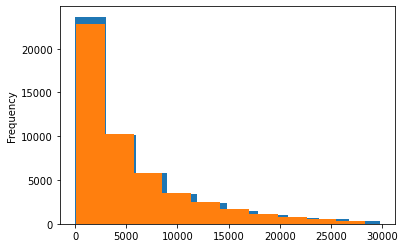

In [180]:
df_sum1[df_sum1['price']<30000]['price'].plot.hist()
df_sum2[df_sum2['price']<30000]['price'].plot.hist()

In [182]:
from sklearn import metrics 

In [183]:
## 简单的随机森林和xgb的线性staaking

#定义stacking简单线性融合的函数
from sklearn import linear_model
def Stacking_method(train_pre1,train_pre2,y_train_true,test_pre1,test_pre2,model_L2= linear_model.LinearRegression()):
    model_L2.fit(pd.concat([pd.Series(train_pre1),pd.Series(train_pre2)],axis=1).values,y_train_true)
    Stacking_result = model_L2.predict(pd.concat([pd.Series(test_pre1),pd.Series(test_pre2)],axis=1).values)
    return Stacking_result

TrainX1=model_xgb_pre.predict(train_reg1_trainx) #大于30000的训练集x的预测值，用于xgb模型
TrainX2=model_xgb_pre1.predict(train_reg2_trainx) #小于等于30000的训练集x的预测值，用于xgb模型
TrainX3=model_for_pre.predict(train_reg3_trainx) #大于30000的训练集x的预测值，用于随机森林模型
TrainX4=model_for_pre1.predict(train_reg4_trainx) #小于等于30000的训练集x的预测值，用于随机森林模型

TrainY13=train_reg1_trainy                        #train_reg1_trainy=train_reg3_trainy，都是真实的训练集大于30000的数据
TrainY24=train_reg2_trainy                        #train_reg2_trainy=train_reg4_trainy，都是真实的训练集小于等于30000的数据

#predict1 2 3 4为先前两个模型测试集的预测值
model_L2= linear_model.LinearRegression()
Test_Y_big = Stacking_method(TrainX1,TrainX3,TrainY13,predict1,predict3,model_L2)    #最后大于30000的数据模型融合的结果
Test_Y_small = Stacking_method(TrainX2,TrainX4,TrainY24,predict2,predict4,model_L2)  #最后小于等于30000的数据模型融合的结果


In [184]:
t5=t3.copy()
df5=pd.DataFrame()
df5['SaleID']=t5.SaleID
df5['price']=Test_Y_big

t6=t4.copy()
df6=pd.DataFrame()
df6['SaleID']=t6.SaleID
df6['price']=Test_Y_small

df_sum_12=pd.concat([df5,df6],axis=0)
df_sum_12=df_sum_12.sort_values(by='SaleID')

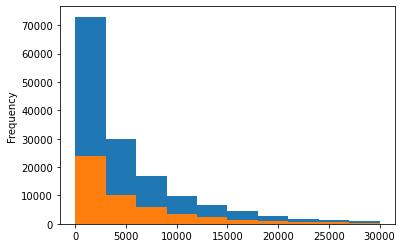

In [197]:
df_sum_12['price']=df_sum_12['price'].apply(lambda x:12 if x< 12 else x)

Train_data[Train_data['price']<30000]['price'].plot.hist()
df_sum_12[df_sum_12['price']<30000]['price'].plot.hist()

In [196]:
df_sum_12['price'].describe()

count     50000.000000
mean       5967.064644
std        7686.363312
min          12.000000
25%        1366.138502
50%        3267.470471
75%        7684.872427
max      100450.793273
Name: price, dtype: float64

In [198]:
df_sum_12.to_csv('G:/sub_Weighted.csv',index=False)

In [ ]:
traindatacopy=Train_data.copy()
testdatacopy=Test_data.copy()

In [203]:
Train_data['usetime'].describe()

count    149998.000000
mean       4541.098381
std        1968.089574
min          92.000000
25%        3053.000000
50%        4566.000000
75%        6024.000000
max        9247.000000
Name: usetime, dtype: float64

In [204]:
bin = [i*365 for i in range(27)]

#数据分桶
Train_data['usetime_bin'] = pd.cut(Train_data['usetime'], bin, labels=[i for i in range(26)]) #用数字代表两者之间的区间

Test_data['usetime_bin'] = pd.cut(Test_data['usetime'], bin, labels=[i for i in range(26)]) #用数字代表两者之间的区间
Test_data[['usetime_bin', 'usetime']].head()

,usetime_bin,usetime
0,4,1572
1,17,6258
2,7,2559
3,5,2180
4,18,6821


In [205]:
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("usetime_bin")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['usetime_amount'] = len(kind_data)
    info['usetime_price_max'] = kind_data.price.max()
    info['usetime_price_median'] = kind_data.price.median()
    info['usetime_price_min'] = kind_data.price.min()
    info['usetime_price_sum'] = kind_data.price.sum()
    info['usetime_price_std'] = kind_data.price.std()
    info['usetime_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
#print(all_info)
#brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})    #逐步分解看怎么操作的
#print(brand_fe)
usetime_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "usetime_bin"})
Train_data = Train_data.merge(usetime_fe, how='left', on='usetime_bin')
Test_data = Test_data.merge(usetime_fe, how='left', on='usetime_bin')
Test_data.head()

,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,v_0,v_1,...,brand_price_average,power_bin,usetime_bin,usetime_amount,usetime_price_max,usetime_price_median,usetime_price_min,usetime_price_sum,usetime_price_std,usetime_price_average
0,222.0,4,5.0,1.0,1.0,313,15.0,0.0,49.59375,5.246094,...,8536.0,13,4,5353.0,88997.0,13000.0,40.0,80285447.0,9004.341773,14995.41
1,19.0,21,0.0,0.0,0.0,75,12.5,1.0,42.40625,-3.253906,...,5720.0,4,17,8567.0,34996.0,1150.0,40.0,14039162.0,2044.831470,1638.56
2,82.0,21,0.0,0.0,0.0,109,7.0,0.0,45.84375,4.703125,...,5720.0,6,7,7361.0,92900.0,7995.0,14.0,70258450.0,6634.305369,9543.39
3,0.0,0,0.0,0.0,1.0,160,7.0,0.0,46.43750,4.320312,...,5536.0,9,5,5780.0,98000.0,11400.0,30.0,75729513.0,8380.252343,13099.73
4,26.0,14,2.0,0.0,0.0,75,15.0,0.0,42.18750,-3.166016,...,3052.0,4,18,6913.0,72900.0,980.0,13.0,10284895.0,2534.760028,1487.55


In [208]:
continuous_feature_names = [x for x in Train_data.columns if x not in 'price']
train_x = Train_data[continuous_feature_names]   #训练集x值

train_y =Train_data['price']       #训练集y值

continuous_feature_names = [x for x in Test_data.columns]

test_x = Test_data[continuous_feature_names]   #测试集x值

In [209]:
#xgb模型调参
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_x, train_y, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (100, 200),
        'learning_rate': (0.05, 0.14),
        'max_depth':(7, 17),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -562.0    |  0.1033   |  10.54    |  168.2    |  0.4954   |
|  2        | -668.6    |  0.1139   |  7.884    |  190.7    |  0.2217   |
|  3        | -559.1    |  0.07325  |  10.97    |  157.8    |  0.6346   |
|  4        | -540.0    |  0.0653   |  13.15    |  195.9    |  0.6384   |
|  5        | -562.6    |  0.1184   |  16.45    |  182.5    |  0.4799   |
|  6        | -545.5    |  0.09155  |  15.77    |  194.9    |  0.6842   |
|  7        | -555.2    |  0.1257   |  14.23    |  195.7    |  0.7136   |
|  8        | -540.4    |  0.05     |  13.09    |  195.9    |  0.6184   |
|  9        | -538.7    |  0.05     |  13.17    |  196.0    |  0.6899   |
|  10       | -539.4    |  0.05     |  13.09    |  196.0    |  0.7808   |
|  11       | -549.7    |  0.1124   |  13.07    |  196.1    |  0.6717   |
|  12       | -542.5    |  0.0902   | 

In [210]:
#定义xgb模型函数
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=196, learning_rate=0.0577, gamma=0, subsample=0.7411,\
        colsample_bytree=0.9, max_depth=13) #,objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train_x,train_y,test_size=0.3)

## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))#最大与最小值的差
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Train xgb...')
model_xgb = build_model_xgb(train_x,train_y)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model1 = build_model_xgb(train_x,train_y)
test_y = model1.predict(test_x)
print('Sta of Predict xgb:')
Sta_inf(test_y)

Train xgb...
MAE of val with xgb: 219.36751312715742
Predict xgb...
Sta of Predict xgb:
_min -76.65445
_max: 91048.62
_mean 5917.9814
_ptp 91125.27
_std 7358.2583
_var 54143970.0


In [213]:
df7=pd.DataFrame()
df7['SaleID']=T.SaleID
df7['price']=test_y
df7['price']=df7['price'].apply(lambda x:10 if x<10 else x)
df7.to_csv('D:/sub_Weighted.csv',index=False)

In [218]:
df7['diff']=df7['price']-sub3['price']
df7['diff1']=df7['price']-df_sum1['price']
print(df7['diff1'].describe())
print(df7['diff'].describe())
print(df7['price'].describe())

count    50000.000000
mean        -5.658359
std        607.239016
min     -25952.419922
25%        -78.589691
50%         -0.174866
75%         77.340698
max      18352.872070
Name: diff1, dtype: float64
count    50000.000000
mean        -2.388639
std        414.933135
min     -12491.818359
25%        -74.012939
50%         -0.356430
75%         71.960968
max       8453.332031
Name: diff, dtype: float64
count    50000.000000
mean      5917.991060
std       7358.324233
min         10.000000
25%       1368.010712
50%       3272.478516
75%       7705.778198
max      91048.617188
Name: price, dtype: float64


In [222]:
df7['diff'].astype(int).sort_values()

29017   -12491
40259    -8129
42330    -7852
3846     -7511
31609    -7356
         ...  
17844     5358
39750     5405
40469     5613
3541      6117
28538     8453
Name: diff, Length: 50000, dtype: int32

In [225]:
TRAINDATA=Train_data.copy()
TESTDATA=Test_data.copy()

In [228]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149998 entries, 0 to 149997
Data columns (total 43 columns):
model                    149998 non-null float16
brand                    149998 non-null int8
bodyType                 149998 non-null float16
fuelType                 149998 non-null float16
gearbox                  149998 non-null float16
power                    149998 non-null int16
kilometer                149998 non-null float16
notRepairedDamage        149998 non-null float16
price                    149998 non-null int32
v_0                      149998 non-null float16
v_1                      149998 non-null float16
v_2                      149998 non-null float16
v_3                      149998 non-null float16
v_4                      149998 non-null float16
v_5                      149998 non-null float16
v_6                      149998 non-null float16
v_7                      149998 non-null float16
v_8                      149998 non-null float16
v_9           

In [229]:
Train_data['bought_time_bin'].value_counts()

10    130492
11     19251
9        210
8         27
6          7
7          5
4          3
3          2
1          1
Name: bought_time_bin, dtype: int64

In [230]:
# 这里要以 train 的数据计算统计量
Train_gb = Train_data.groupby("kilometer")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['kilometer_price_max'] = kind_data.price.max()
    info['kilometer_price_std'] = kind_data.price.std()
    info['kilometer_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
usetime_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "kilometer"})
Train_data = Train_data.merge(usetime_fe, how='left', on='kilometer')
Test_data = Test_data.merge(usetime_fe, how='left', on='kilometer')

Train_gb = Train_data.groupby("fuelType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['fuelType_price_max'] = kind_data.price.max()
    info['fuelType_price_std'] = kind_data.price.std()
    info['fuelType_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
usetime_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "fuelType"})
Train_data = Train_data.merge(usetime_fe, how='left', on='fuelType')
Test_data = Test_data.merge(usetime_fe, how='left', on='fuelType')

Train_gb = Train_data.groupby("bodyType")
all_info = {}
for kind, kind_data in Train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['bodyType_price_max'] = kind_data.price.max()
    info['bodyType_price_std'] = kind_data.price.std()
    info['bodyType_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
usetime_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "bodyType"})
Train_data = Train_data.merge(usetime_fe, how='left', on='bodyType')
Test_data = Test_data.merge(usetime_fe, how='left', on='bodyType')

Test_data.head()

,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,v_0,v_1,...,usetime_price_average,kilometer_price_max,kilometer_price_std,kilometer_price_average,fuelType_price_max,fuelType_price_std,fuelType_price_average,bodyType_price_max,bodyType_price_std,bodyType_price_average
0,222.0,4,5.0,1.0,1.0,313,15.0,0.0,49.59375,5.246094,...,14995.41,99999.0,4494.769646,3825.44,99999.0,8185.950469,8697.66,99999.0,12388.087242,10292.61
1,19.0,21,0.0,0.0,0.0,75,12.5,1.0,42.40625,-3.253906,...,1638.56,87900.0,6699.991616,6364.63,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
2,82.0,21,0.0,0.0,0.0,109,7.0,0.0,45.84375,4.703125,...,9543.39,85911.0,9623.507957,11011.20,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
3,0.0,0,0.0,0.0,1.0,160,7.0,0.0,46.43750,4.320312,...,13099.73,85911.0,9623.507957,11011.20,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
4,26.0,14,2.0,0.0,0.0,75,15.0,0.0,42.18750,-3.166016,...,1487.55,99999.0,4494.769646,3825.44,99999.0,6836.239888,4647.47,69900.0,6326.130000,5820.47


In [231]:
df_lasttrain=pd.DataFrame()
df_lasttrain['pricehat']=model1.predict(train_x)

df_lasttrain['kilometer_price_max']=Train_data['kilometer_price_max']
df_lasttrain['kilometer_price_std']=Train_data['kilometer_price_std']
df_lasttrain['kilometer_price_average']=Train_data['kilometer_price_average']

df_lasttrain['fuelType_price_max']=Train_data['fuelType_price_max']
df_lasttrain['fuelType_price_std']=Train_data['fuelType_price_std']
df_lasttrain['fuelType_price_average']=Train_data['fuelType_price_average']

df_lasttrain['bodyType_price_max']=Train_data['bodyType_price_max']
df_lasttrain['bodyType_price_std']=Train_data['bodyType_price_std']
df_lasttrain['bodyType_price_average']=Train_data['bodyType_price_average']

df_lasttrain.head()

,pricehat,kilometer_price_max,kilometer_price_std,kilometer_price_average,fuelType_price_max,fuelType_price_std,fuelType_price_average,bodyType_price_max,bodyType_price_std,bodyType_price_average
0,2002.461914,87900.0,6699.991616,6364.63,99999.0,6836.239888,4647.47,99999.0,3158.898609,2789.36
1,3683.500977,99999.0,4494.769646,3825.44,99999.0,6836.239888,4647.47,69900.0,6326.130000,5820.47
2,6773.818848,87900.0,6699.991616,6364.63,99999.0,6836.239888,4647.47,99999.0,3158.898609,2789.36
3,2784.069824,99999.0,4494.769646,3825.44,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
4,5390.518066,99990.0,11060.099213,13571.85,99999.0,6836.239888,4647.47,99999.0,3158.898609,2789.36


In [232]:
df_lasttrain['pricehat']=df_lasttrain['pricehat'].apply(lambda x:10 if x<10 else x)

In [234]:
df_lasttest=pd.DataFrame()
df_lasttest['pricehat']=df7['price']

df_lasttest['kilometer_price_max']=Test_data['kilometer_price_max']
df_lasttest['kilometer_price_std']=Test_data['kilometer_price_std']
df_lasttest['kilometer_price_average']=Test_data['kilometer_price_average']

df_lasttest['fuelType_price_max']=Test_data['fuelType_price_max']
df_lasttest['fuelType_price_std']=Test_data['fuelType_price_std']
df_lasttest['fuelType_price_average']=Test_data['fuelType_price_average']

df_lasttest['bodyType_price_max']=Test_data['bodyType_price_max']
df_lasttest['bodyType_price_std']=Test_data['bodyType_price_std']
df_lasttest['bodyType_price_average']=Test_data['bodyType_price_average']

df_lasttest.head()

,pricehat,kilometer_price_max,kilometer_price_std,kilometer_price_average,fuelType_price_max,fuelType_price_std,fuelType_price_average,bodyType_price_max,bodyType_price_std,bodyType_price_average
0,36968.121094,99999.0,4494.769646,3825.44,99999.0,8185.950469,8697.66,99999.0,12388.087242,10292.61
1,322.917023,87900.0,6699.991616,6364.63,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
2,6582.872070,85911.0,9623.507957,11011.20,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
3,11925.357422,85911.0,9623.507957,11011.20,99999.0,6836.239888,4647.47,99999.0,6932.760706,5693.34
4,611.073547,99999.0,4494.769646,3825.44,99999.0,6836.239888,4647.47,69900.0,6326.130000,5820.47


In [ ]:
continuous_feature_names = [x for x in df_lasttrain.columns]
train_x = df_lasttrain[continuous_feature_names]   #训练集x值

continuous_feature_names = [x for x in df_lasttest.columns]
test_x = df_lasttest[continuous_feature_names]   #测试集x值

train_y=Train_data['price']                       #训练集y值

In [236]:
#xgb模型调参
from bayes_opt import BayesianOptimization
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

#rf = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,colsample_bytree=0.9, max_depth=7)
rf = xgb.XGBRegressor()
def rf_cv(n_estimators, max_depth,subsample,learning_rate):
    val = cross_val_score(
        XGBRegressor(
            subsample=subsample,
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            learning_rate=learning_rate
        ),
        train_x, train_y, scoring=make_scorer(mean_absolute_error), cv=4,verbose=0
    ).mean()
    return 1-val
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (100, 200),
        'learning_rate': (0.05, 0.14),
        'max_depth':(7, 17),
        'subsample':(0.1,1)}
    )

rf_bo.maximize()

|   iter    |  target   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------
|  1        | -557.5    |  0.1355   |  14.18    |  188.2    |  0.6904   |
|  2        | -545.4    |  0.09488  |  14.33    |  170.8    |  0.7006   |
|  3        | -554.3    |  0.1007   |  16.43    |  103.9    |  0.8315   |
|  4        | -563.2    |  0.1278   |  14.82    |  179.5    |  0.5128   |
|  5        | -603.1    |  0.06124  |  9.613    |  169.2    |  0.355    |
|  6        | -600.8    |  0.05832  |  14.47    |  199.9    |  0.1186   |
|  7        | -541.7    |  0.06394  |  14.26    |  189.2    |  0.9037   |
|  8        | -540.9    |  0.06605  |  14.33    |  189.2    |  0.8782   |
|  9        | -557.8    |  0.1279   |  14.39    |  189.1    |  0.6507   |
|  10       | -548.6    |  0.05325  |  14.49    |  170.8    |  0.4777   |
|  11       | -556.8    |  0.1291   |  14.47    |  151.7    |  0.8749   |
|  12       | -550.1    |  0.1166   | 

In [237]:
#定义xgb模型函数
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=189, learning_rate=0.06605, gamma=0, subsample=0.8782,\
        colsample_bytree=0.9, max_depth=14) #,objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(train_x,train_y,test_size=0.3)

## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))#最大与最小值的差
    print('_std',np.std(data))
    print('_var',np.var(data))
    
print('Train xgb...')
model_xgb = build_model_xgb(train_x,train_y)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model2 = build_model_xgb(train_x,train_y)
test_y = model2.predict(test_x)
print('Sta of Predict xgb:')
Sta_inf(test_y)

Train xgb...
MAE of val with xgb: 147.81810631034904
Predict xgb...
Sta of Predict xgb:
_min -24.990963
_max: 90029.22
_mean 5916.392
_ptp 90054.21
_std 7357.9243
_var 54139052.0


In [238]:
df8=pd.DataFrame()
df8['SaleID']=T.SaleID
df8['price']=test_y
df8['price']=df8['price'].apply(lambda x:10 if x<10 else x)
df8.to_csv('G:/sub_Weighted.csv',index=False)

In [239]:
df8['price'].describe()

count    50000.000000
mean      5916.395143
std       7357.995678
min         10.000000
25%       1365.389984
50%       3280.475342
75%       7711.568115
max      90029.218750
Name: price, dtype: float64

In [241]:
df9=pd.DataFrame()
df9['SaleID']=T.SaleID
df9['price']=0.4*df8['price']+0.35*df7['price']+0.25*df_sum1['price']
df9['price']=df9['price'].apply(lambda x:10 if x<10 else x)
df9.to_csv('F:/sub_Weighted.csv',index=False)
df9['price'].describe()

count    50000.000000
mean      5918.767283
std       7363.116054
min         10.000000
25%       1369.651656
50%       3279.444360
75%       7714.607294
max      91069.875391
Name: price, dtype: float64

In [242]:
df10=pd.DataFrame()
df10['SaleID']=T.SaleID
df10['price']=0.4*df8['price']+0.35*df7['price']+0.25*df_sum_12['price']
df10['price']=df10['price'].apply(lambda x:10 if x<10 else x)
df10.to_csv('G:/sub_Weighted.csv',index=False)
df10['price'].describe()

count    50000.000000
mean      5929.621089
std       7430.121725
min         10.500000
25%       1369.472483
50%       3276.820309
75%       7708.627036
max      91700.718240
Name: price, dtype: float64

In [243]:
df11=pd.DataFrame()
df11['SaleID']=T.SaleID
df11['price']=np.sqrt(df7['price']*df8['price'])
df11['price']=df10['price'].apply(lambda x:10 if x<10 else x)
df11['price'].describe()

count    50000.000000
mean      5929.621089
std       7430.121725
min         10.500000
25%       1369.472483
50%       3276.820309
75%       7708.627036
max      91700.718240
Name: price, dtype: float64

In [244]:
df11.to_csv('E:/sub_Weighted.csv',index=False)

In [246]:
df12=pd.DataFrame()
df12['SaleID']=T.SaleID
df12['price']=0.34*df10['price']+0.33*df11['price']+0.33*df9['price']
df12['price']=df12['price'].apply(lambda x:10 if x<10 else x)
df12.to_csv(r'C:\Users\Administrator.RPK-20180123GWR\Desktop\df12\sub_Weighted.csv',index=False)
df12['price'].describe()

count    50000.000000
mean      5926.039333
std       7407.712740
min         10.335000
25%       1369.434096
50%       3277.544230
75%       7709.354059
max      90936.531246
Name: price, dtype: float64

In [247]:
df13=pd.DataFrame()
df13['SaleID']=T.SaleID
df13['price']=np.power(df10['price']*df11['price']*df9['price'],1/3)
df13['price']=df13['price'].apply(lambda x:10 if x<10 else x)
df13.to_csv(r'C:\Users\Administrator.RPK-20180123GWR\Desktop\df13\sub_Weighted.csv',index=False)
df13['price'].describe()

count    50000.000000
mean      5925.941017
std       7407.166223
min         10.330616
25%       1369.430196
50%       3277.526150
75%       7709.353193
max      90937.146276
Name: price, dtype: float64